In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
%matplotlib inline

In [3]:
import tensorflow as tf
import numpy

import matplotlib.pyplot as plt

In [4]:
# From http://stackoverflow.com/questions/38189119/simple-way-to-visualize-a-tensorflow-graph-in-jupyter
# make things wide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()
        
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)
    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')
        #print(data)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))

Please note that the graph visualizations only work in Chrome :(

In [53]:
tf.reset_default_graph()

In [54]:
# Allocate inputs and outputs

# Placeholders are nodes in the graph whose values need to be 
# provded using feeds
#
# A note about shapes: unlike the Math convention (col-major)
# Python is row-major and everything we do will be transposed
X = tf.placeholder('float32', shape=(None, 2), name='X')
Y = tf.placeholder('float32', shape=(None, 1), name='Y')

In [55]:
def affine_layer(X, num_hidden, activation=None, name=None):
    name = name or "affine_layer"
    with tf.variable_scope(None, default_name=name):
        W = tf.get_variable('W', (X.shape[1].value, num_hidden), 'float32',
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('b', (1, num_hidden), 'float32',
                            initializer=tf.zeros_initializer())
        Y = tf.matmul(X, W) + b
        if activation:
            Y = activation(Y)
        return Y

In [56]:
Output = affine_layer(X, 10, tf.nn.relu)
Output = affine_layer(Output, 1)
Loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(Output, Y))

In [57]:
# show_graph()

In [58]:
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(Loss)
global_step = tf.get_variable('global_step', shape=(), dtype='int32', 
                              trainable=False)
train_op = tf.group(train_op, tf.assign_add(global_step, 1))

In [59]:
initialize_op = tf.global_variables_initializer()

In [60]:
sess = tf.InteractiveSession()

In [61]:
sess.run(initialize_op)

(-1.5, 1.5, -1.5, 1.5)

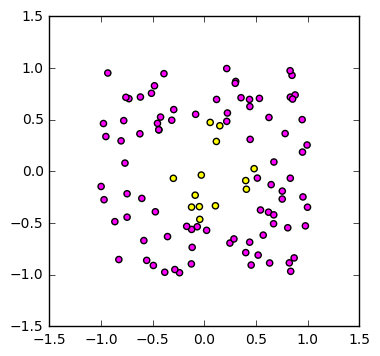

In [63]:
DataX = np.random.rand(100, 2)*2.0 - 1.0
DataY = np.sum((DataX**2), axis=1) < 0.5**2
DataY = np.reshape(DataY, (-1,1))

plt.scatter(DataX[:,0], DataX[:,1], c=DataY, cmap='spring')
plt.axis('square')

In [ ]:
# train for a while

sess.run(initialize_op)

loss_history = []
use_batch=False

global_step_v = sess.run(global_step)
epoch = 0

while global_step_v < 100000:
    epoch += 1
    # Batch grad descent
    if use_batch:
        feed_dicts=[{X:DataX, Y:DataY}]
    else: # SGD
        data_shuffle = np.random.permutation(DataX.shape[0])
        feed_dicts = []
        batch_size = 10
        for batch_start in range(0, DataX.shape[0] - batch_size + 1, batch_size):
            batch_idx = data_shuffle[batch_start:batch_start+batch_size]
            feed_dicts.append({X:DataX[batch_idx], Y:DataY[batch_idx]})
    
    for feed_dict in feed_dicts:
        _, global_step_v, loss_v = sess.run([train_op, global_step, Loss], feed_dict=feed_dict)
        if (global_step_v % 1000) == 1:
            loss_history.append((epoch, global_step_v, loss_v,))
            print ("epoch: %d, step: %d, loss: %g" % (epoch, global_step_v, loss_v,))

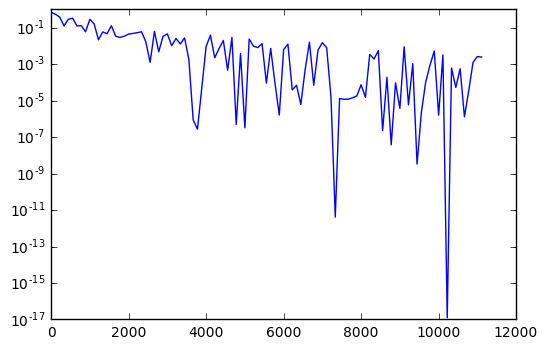

In [78]:
loss_history = np.array(loss_history)
plt.semilogy(loss_history[:,0], loss_history[:,2])

In [79]:
meshX = np.meshgrid(np.linspace(-1.5, 1.5, 100), np.linspace(-1.5, 1.5, 100))
meshX = np.hstack([m.reshape(-1, 1) for m in meshX])

In [80]:
Output_v = sess.run(Output, feed_dict={X: meshX})

(-2.0, 2.0, -2.0, 2.0)

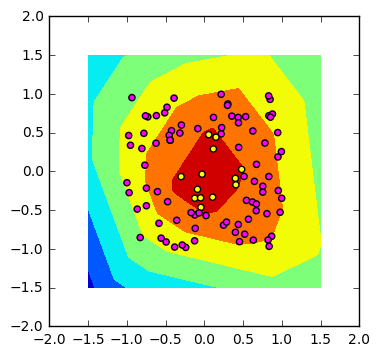

In [81]:
plt.contourf(meshX[:,0].reshape(100,100), meshX[:,1].reshape(100,100), Output_v.reshape(100,100))
plt.scatter(DataX[:,0], DataX[:,1], c=DataY, cmap='spring')
plt.axis('square')

In [82]:
# show_graph()